In [216]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from sklearn.neighbors import BallTree
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 500)

### 1. Read SCM & ERA data

In [217]:
# Read ERA data
era_final = pd.read_csv("files/ERA/processed/era_final_features.csv")
era_raw = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments.csv").assign(model="ERA", init_month=12)

# Read and preprocess hindcast data from different climate models
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")
scm = pd.concat([nmme, c3s, apcc], ignore_index=True).drop_duplicates()
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(9, 11))].reset_index(drop=True)

# Store variables used throughout the notebook
climate_models = scm["model"].unique().tolist()
climate_models.sort()
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set([c.split("_")[1] for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

# Extract raw weather columns based on basis expansion needed for final features
weather_columns_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("tmean" in c)]),
                                        dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in weather_columns_final if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            weather_columns_raw.append("{}_{}_{}".format(var, loc, month))
            
era_raw = era_raw.loc[:, ["year", "model", "init_month"] + weather_columns_raw]

# Display a random sample from the processed hindcast data
scm.sample(2)


,model,year,init_month,forecasted_month,rain,tmean,lat,lon
186378,DWD,2015,10,10,0.000760,20.889673,-32.0,-67.0
118999,NCEP,2008,9,10,0.002315,16.800989,-36.0,-62.0


### 2. Filter SCM locations

**2.1 Obtain polygon shapes of relevant municipalities**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. SCM data is often provided in e.g. 1° x 1° or 2.5° x 2.5° grid cells. For each location, we need to find the *k* grid cells that are closest. 

In [218]:
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_municipalities), ["name", "geometry"]].reset_index(drop=True)
relevant_municipalities = gdf_adm2["name"].unique().tolist()
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
name_to_shape

{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**2.2 Preview SCM locations and relevant municipality locations**

<Axes: >

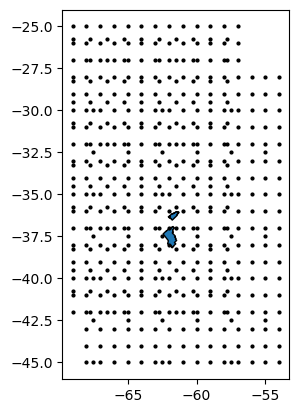

In [219]:
# Convert SCM dataframe to geodataframe to facilitate spatial filtering in the next section
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"]), crs="EPSG:4326")
base = gdf_adm2["geometry"].plot(edgecolor="black")
gpd.GeoDataFrame(scm.loc[:, ["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base, color="black", markersize=4)

**2.3 Filter SCM hindcasts**

For each relevant municipality, we select K grid cell locations from each SCM that are closest to that municipality. If a SCM has a sparse resolution, it may be that the same grid cell is used for both locations.

In [249]:
def get_nearest_neighbors(src_points, candidate_points, k_neighbors=2):
    """
    Find k nearest neighbors for all source points from a set of candidate points
    modified from: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html    
    params:
        src_points : geopandas.DataFrame Geometries to search from.
        candidate_points : geopandas.DataFrame Geoemtries to be searched.
        k_neighbors : int, optional Number of nearest neighbors. The default is 2.
    returns:
        tuple containing lists of indices of the closest and second closest locations 
    """
    src_points = [(x,y) for x,y in zip(src_points.geometry.centroid.x , src_points.geometry.centroid.y)]
    candidates =  [(x,y) for x,y in zip(candidate_points.geometry.x , candidate_points.geometry.y)]
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')
    distances, indices = tree.query(src_points, k=k_neighbors)
    distances = distances.transpose()
    indices = indices.transpose()
    closest = indices[0]
    second_closest = indices[1] 

    return (closest, second_closest)

In [250]:
filtered_scm = []
for model in climate_models:
    coordinates_of_scm = scm.loc[scm["model"] == model, ["model", "geometry"]].drop_duplicates().reset_index(drop=True).copy()
    (ids_closest, ids_second_closest) = get_nearest_neighbors(gdf_adm2, coordinates_of_scm, 2)
    filtered_coordinates = coordinates_of_scm.iloc[list(ids_closest) + list(ids_second_closest)].reset_index(drop=True)
    filtered_coordinates = filtered_coordinates.assign(name=pd.Series(2 * relevant_municipalities))
    filtered_scm.append(scm.loc[scm["model"] == model].merge(filtered_coordinates[["name", "geometry"]], on="geometry", how="right"))
    
filtered_scm = pd.concat(filtered_scm, ignore_index=True)

<Axes: >

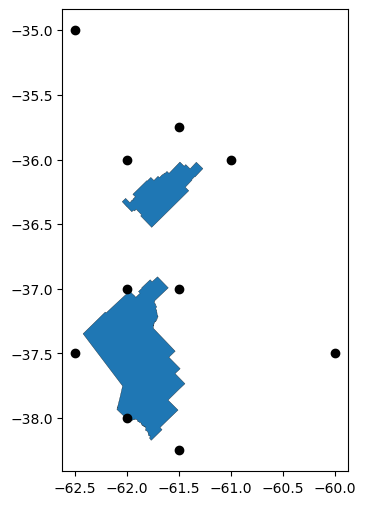

In [251]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gpd.GeoDataFrame(filtered_scm[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 3. Bring SCM hindcasts into feature structure

In [252]:
li =[]
for m in relevant_municipalities:
    df = filtered_scm.loc[filtered_scm["name"] == m].pivot_table(
        index=["model", "year", "init_month", "lat", "lon"],
        columns=["name", "forecasted_month"],
        values=["tmean", "rain"]
    ).reset_index()
    df.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in df.columns]
    df.columns = [c.strip("_") for c in df.columns]
    df = df.set_index(["model", "year", "init_month", "lat", "lon"])
    li.append(df)

scm_pivot = pd.concat(li, axis=1, join="outer").reset_index().sort_values(by=["model", "year", "init_month", "lat", "lon"]).reset_index(drop=True)
scm_pivot = scm_pivot.loc[:, ["year", "model", "init_month"] + ["lat", "lon"] + weather_columns_raw]
scm_pivot.sample(3)

,year,model,init_month,lat,lon,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
603,2001,CMCC,9,-36.0,-61.0,NaN,NaN,NaN,NaN,0.001507
2616,1995,KMA,11,-37.5,-62.5,NaN,19.024591,NaN,0.002304,NaN
3534,2005,NCEP,10,-36.0,-62.0,NaN,NaN,NaN,NaN,NaN


### 4. Adjust Bias

In [253]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in [9, 10, 11]:
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [254]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
1886,GFDL,1994,9,NaN,NaN,NaN,NaN,0.001571
3822,PNU,2009,11,NaN,16.070417,NaN,0.003898,NaN
2499,JMA,2006,11,NaN,15.761543,NaN,0.002591,NaN


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [255]:
def standardize_loyo(scm_df, era_df):
    scm_df = scm_df.copy()
    era_df = era_df.copy()
    standardized_data = []
    for model in scm_df["model"].unique():
        standardized_data_init_month = []
        for month in scm_df["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = era_df.loc[(era_df["year"] != year), [c for c in era_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), [c for c in scm_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_df.loc[:, [c for c in [l for l in standardized_df.columns if ("tmean" in l) or ("rain" in l)] if (int(c.split("_")[-1]) < month)]] = np.nan
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(scm_df, era_raw_df, era_final_df, final_features):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(scm_df, era_raw_df)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])

    for col in final_features:
        type_of_expansion = col.split("_")[0]
        location = col.split("_")[1]
        month = col.split("_")[2]
        
        if type_of_expansion == "tmeansquared":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            df_standardized[col] = tmean.mul(tmean)
        if type_of_expansion == "rainsquared":
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain.mul(rain)
        if type_of_expansion == "tmeanrain":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain * tmean.values
    
    df_standardized = df_standardized[final_features].reset_index()
    
    # standardize expanded features again
    df_standardized = standardize_loyo(df_standardized, era_final_df)
    df_standardized = df_standardized.groupby(["model", "year", "init_month"]).mean()[final_features].reset_index()
    
    return df_standardized

In [256]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted, era_raw, era_final, weather_columns_final)
scm_basis_expansion.sample(3)

,model,year,init_month,tmeanrain_buenos aires coronel suarez_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires coronel suarez_11,tmeansquared_buenos aires coronel suarez_11
516,GFDL,1997,9,-0.157857,0.097315,-0.067271,0.196798
1103,UKMO,2000,11,NaN,NaN,0.447770,0.172850
681,JMA,2004,9,-0.144933,-0.038549,-0.082049,-0.077958


In [258]:
scm_basis_expansion.loc[(scm_basis_expansion["model"] == "GFDL") & (scm_basis_expansion["init_month"] == 9) & (scm_basis_expansion["year"] == 2014), ["rainsquared_buenos aires hipolito yrigoyen_9"]]

,rainsquared_buenos aires hipolito yrigoyen_9
567,5.627199


In [259]:
scm_bias_adjusted.loc[(scm_bias_adjusted["model"] == "GFDL") & (scm_bias_adjusted["init_month"] == 9) & (scm_bias_adjusted["year"] == 2014), ["rain_buenos aires hipolito yrigoyen_9"]]

,rain_buenos aires hipolito yrigoyen_9
2124,NaN
2125,NaN
2126,0.005515
2127,0.006151


In [260]:
scm_bias_adjusted.loc[(scm_bias_adjusted["model"] == "NASA") & (scm_bias_adjusted["init_month"] == 9) & (scm_bias_adjusted["year"] == 2014), ["rain_buenos aires hipolito yrigoyen_9"]]

,rain_buenos aires hipolito yrigoyen_9
3348,NaN
3349,NaN
3350,0.003355
3351,0.003362


In [261]:
era_raw.loc[ (era_raw["year"] == 2014), ["rain_buenos aires hipolito yrigoyen_9"]]

,rain_buenos aires hipolito yrigoyen_9
21,0.001556


In [262]:
era_final.loc[ (era_final["year"] == 2014), ["rainsquared_buenos aires hipolito yrigoyen_9"]]

,rainsquared_buenos aires hipolito yrigoyen_9
21,-0.500335


### 6. Fill unskillful months with climatology

#### 6.1 Detect unskillful SCM using out-of-sample R<sup>2</sup>

In [263]:
def r2_by_feature_init_month_and_scm(init_month, climate_models, era_df, scm_df, features):
    model_to_col_to_r2 = dict.fromkeys(climate_models)
    loyo_mean = (era_df[features].sum() - era_df[features]) / (era_df.shape[0] - 1)
    
    for model in climate_models:
        forecasted_scm = scm_df.xs(init_month, level=2, drop_level=True).xs(model, level=0, drop_level=True)[features]
        
        ss_total = mse(era_df[features], loyo_mean, multioutput="raw_values")
        ss_model = mse(era_df[features], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        model_to_col_to_r2[model] = dict(zip(features, current_r2))

    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

r2_9 = r2_by_feature_init_month_and_scm(9, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), weather_columns_final)
r2_10 = r2_by_feature_init_month_and_scm(10, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), [c for c in weather_columns_final if ("_9" not in c)])
r2_11 = r2_by_feature_init_month_and_scm(11, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), [c for c in weather_columns_final if ("_11" in c)])

#r2_by_init = r2_9.merge(r2_10.merge(r2_11, left_index=True, right_index=True, suffixes=("", "_11"), how="outer"), left_index=True, right_index=True, suffixes=("_9", "_10"), how="outer")
r2_by_init = pd.concat([r2_9, r2_10, r2_11])
r2_10

,BOM,CCSM4,CMCC,CWB,DWD,ECCC,ECMWF,GFDL,HMC,JMA,KMA,METFR,NASA,NCEP,PNU,UKMO
tmeanrain_buenos aires coronel suarez_11,0.284813,0.106131,0.057501,0.273864,0.026523,0.199898,0.422996,0.309256,0.068990,0.135426,0.424636,0.088438,NaN,NaN,NaN,NaN
tmeansquared_buenos aires coronel suarez_11,0.496426,0.328780,0.374945,0.517165,0.092985,0.840169,0.853244,0.755283,0.457864,0.273923,0.590114,0.331835,0.599531,0.217347,0.214969,0.174854


### 5. Fill past months with ERA data

In [264]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.loc[scm_era["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires coronel suarez_11,tmeansquared_buenos aires coronel suarez_11
301,1997,DWD,10,0.175913,0.760139,-0.440915,0.239233,0.121440
147,1994,CMCC,9,0.018138,0.564335,0.229198,0.015063,0.117727
297,1996,DWD,9,0.040968,0.013946,-0.089579,-0.560501,0.433031
173,2002,CMCC,11,-0.159990,0.523275,-0.640879,-0.050151,-0.021347
254,2005,CWB,11,0.029549,0.425555,-0.582333,-0.135345,-0.060463


### 7. Analyse Bias

In [265]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

In [266]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in scm_models:
    for month in init_months:
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        current_scm_bias = abs(current_scm[weather_columns] - era_bias)
        current_scm_info = current_scm[['model', 'init_month', 'yield anomaly [%]']]
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_bias.append(current_scm)
all_bias = pd.concat(all_bias)

In [267]:
all_bias = all_bias.set_index(["model", "init_month"]).stack().reset_index()
all_bias.columns = ["model", "init_month", "feature", "bias"]

<Axes: ylabel='model'>

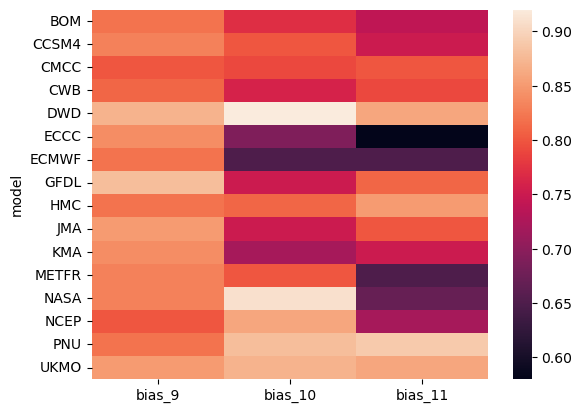

In [268]:
bias_heatmap = (all_bias.loc[(all_bias["init_month"] == 9)].groupby("model")["bias"].mean().reset_index()
                .merge(all_bias.loc[(all_bias["init_month"] == 10)].groupby("model")["bias"].mean().reset_index()
                        .merge(all_bias.loc[(all_bias["init_month"] == 11)].groupby("model")["bias"].mean().reset_index(), on="model", suffixes=("", "_11")), on="model", suffixes=("_9", "_10"))
                .round(2))
sns.heatmap(bias_heatmap.set_index("model"))

<Axes: xlabel='bias', ylabel='feature'>

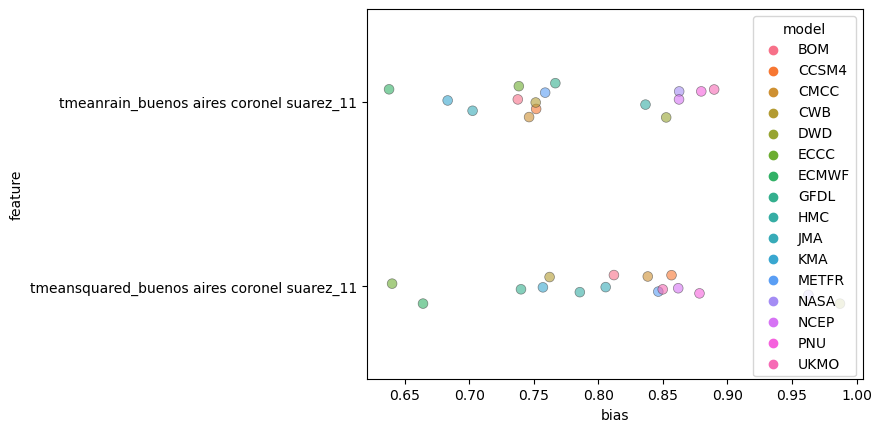

In [269]:
sns.stripplot(data=all_bias.loc[(all_bias["init_month"] == 10)], x="bias", y="feature", orient="h", s=7, linewidth=0.5, alpha=.6, hue="model", jitter=True, size=(20,20))

## EXPORT

In [270]:
scm_era.to_csv("files/ERA/processed/era_scm_final_features.csv", index=False)